# LSTM for Time Series Forecasting

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [6]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [7]:
# load dataset
series = read_csv('monthly-sunspot-number-zurich-17.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [8]:
series.head()

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: Monthly sunspot number, dtype: float64

In [9]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [10]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [12]:
print(supervised_values)

[[  0.    4.6]
 [  4.6   7.4]
 [  7.4 -14.3]
 ..., 
 [-21.5   5.5]
 [  5.5 -22.5]
 [-22.5   0.1]]


In [13]:
supervised_values.shape

(2819, 2)

In [14]:
# split data into train and test-sets
train, test = supervised_values[0:-2184], supervised_values[-2184:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [16]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()

In [17]:
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=46.472594, Expected=47.800000
Month=2, Predicted=49.372589, Expected=47.000000
Month=3, Predicted=49.361521, Expected=40.800000
Month=4, Predicted=44.792625, Expected=42.000000
Month=5, Predicted=43.904100, Expected=44.000000
Month=6, Predicted=45.047410, Expected=46.000000
Month=7, Predicted=46.995104, Expected=48.000000
Month=8, Predicted=49.078269, Expected=50.000000
Month=9, Predicted=51.119771, Expected=51.800000
Month=10, Predicted=52.998331, Expected=38.500000
Month=11, Predicted=43.882495, Expected=34.500000
Month=12, Predicted=38.531931, Expected=50.000000
Month=13, Predicted=45.166105, Expected=50.000000
Month=14, Predicted=50.063066, Expected=50.800000
Month=15, Predicted=52.408051, Expected=29.500000
Month=16, Predicted=36.020880, Expected=25.000000
Month=17, Predicted=29.412769, Expected=44.300000
Month=18, Predicted=37.259062, Expected=36.000000
Month=19, Predicted=36.894922, Expected=48.300000
Month=20, Predicted=45.101548, Expected=34.100000
Month=21,

In [18]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-2184:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.803


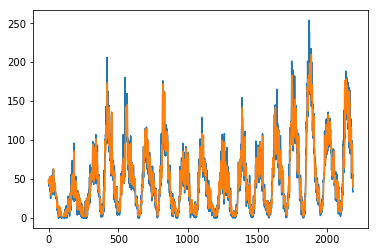

In [19]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-2184:])
pyplot.plot(predictions)
pyplot.show()

In [20]:
raw_values.shape

(2820,)

In [24]:
print(len(predictions))

2184
